In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [ ]:
class CustomGaussianMixture(GaussianMixture):
    def _estimate_covariances(self, resp, X, nk, means):
        if self.covariance_type == 'tied_diag':
            # Calculate shared diagonal covariance matrix
            avg_X2 = np.dot(resp.T, X ** 2) / nk[:, np.newaxis]
            avg_means2 = means ** 2
            covariances = avg_X2 - avg_means2
            # Make the covariance diagonal
            self.covariances_ = np.diag(np.mean(covariances, axis=0))

        else:
            # Use the default sklearn methods for other covariance types
            print("supper")
            super()._estimate_covariances(resp, X, nk, means)

In [76]:
# Clusters dasta
clusters = [
    {"mean": [-6, 8], "cov": [[0.4, 0], [0, 0.4]]},
    {"mean": [-4, 7], "cov": [[1, 2], [2, 5]]},
    {"mean": [8, -6], "cov": [[0.4, 0], [0, 0.4]]},
    {"mean": [4, -10], "cov": [[1, 2], [2, 5]]}
]

# Generate the dta points
data = []
for cluster in clusters:
    points = np.random.multivariate_normal(cluster["mean"], cluster["cov"], 100)
    data.append(points)

# Concatenate all data points
data = np.vstack(data)

In [ ]:
# Initialize GMM with tied spherical covariance
gmm = GaussianMixture(n_components=4, covariance_type='tied')

# Fit the GMM to the data
gmm.fit(data)

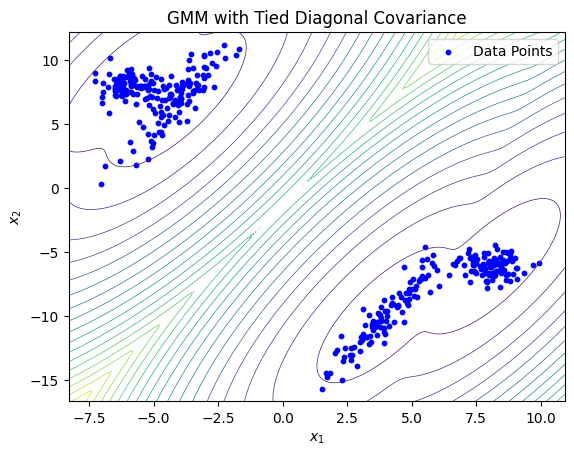

In [73]:
# Generate a mesh grid to plot the GMM contours
x = np.linspace(data[:, 0].min() - 1, data[:, 0].max() + 1, 200)
y = np.linspace(data[:, 1].min() - 1, data[:, 1].max() + 1, 200)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Calculate the GMM's density for each point on the grid
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], s=10, color='blue', label="Data Points")
plt.contour(X, Y, Z, levels=20, cmap="viridis", linewidths=0.5)
plt.title("GMM with Tied Diagonal Covariance")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()